In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
counts = pd.read_csv('GSE59873_RAW/GSM1448819_dr_15ss_TH2.txt.gz', sep='\t', index_col=0).T

sample_info = pd.DataFrame(index=counts.index)
sample_info['x'] = (sample_info.index.values.astype(float) - 1) * 18

# Make orientation head-to-tail because it's easier to think about
sample_info['x'] = sample_info.x.max() - sample_info.x

sample_info['total_count'] = counts.sum(1)
sample_info['num_detected'] = (counts > 0).sum(1)
sample_info['ERCC_counts'] = counts.loc[:, counts.columns.str.startswith('ERCC-')].sum(1)

sample_info = sample_info.query('total_count > 1e4')  # Remove empty features
counts = counts.loc[sample_info.index]

counts = counts.T[counts.sum(0) >= 3].T  # Remove practically unobserved genes

In [3]:
gene_names = pd.read_csv('gene_info.txt', sep='\t', index_col=0)['Gene name']
name_getter = lambda s: str(s) + '_' + str(gene_names.get(s, s))
counts.columns = counts.columns.map(name_getter)

In [4]:
counts.shape

(95, 20317)

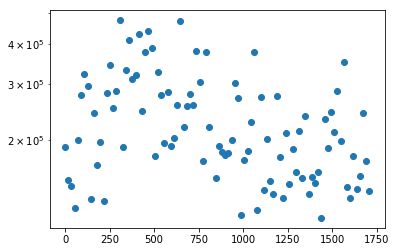

In [5]:
plt.scatter(sample_info.x, sample_info.total_count);
plt.yscale('log');

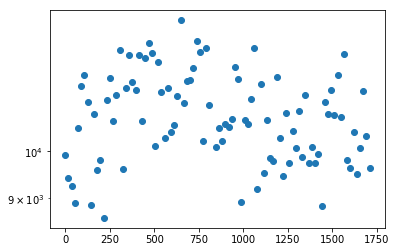

In [6]:
plt.scatter(sample_info.x, sample_info.num_detected);
plt.yscale('log');

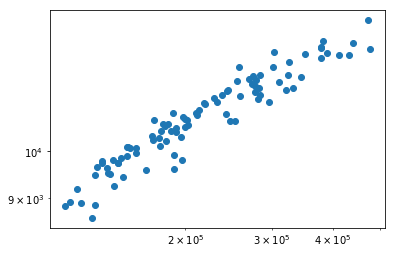

In [7]:
plt.scatter(sample_info.total_count, sample_info.num_detected)
plt.loglog();

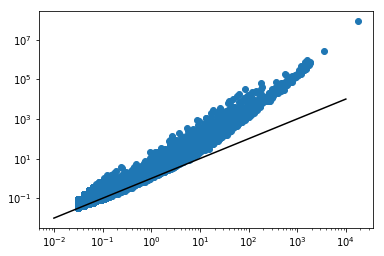

In [8]:
plt.loglog()
plt.scatter(counts.mean(0), counts.var(0))
plt.plot([1e-2, 1e4], [1e-2, 1e4], c='k');

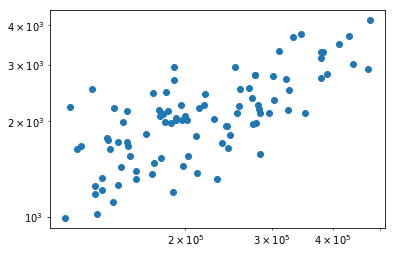

In [9]:
plt.scatter(sample_info.total_count, sample_info.ERCC_counts)
plt.loglog();

In [10]:
import NaiveDE

In [11]:
dfm = NaiveDE.stabilize(counts.T).T

In [12]:
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_count) + np.log(ERCC_counts) + np.log(num_detected)').T
res = res - res.mean()

In [17]:
import SpatialDE

In [18]:
X = sample_info.x.values[:, None]

In [19]:
results = SpatialDE.run(X, res)

INFO:root:Performing DE test
INFO:root:Pre-calculating USU^T = K's ...
INFO:root:Done: 0.014s
INFO:root:Fitting gene models
INFO:root:Model 1 of 10
INFO:root:Model 2 of 10                               
INFO:root:Model 3 of 10                               
INFO:root:Model 4 of 10                               
INFO:root:Model 5 of 10                               
INFO:root:Model 6 of 10                               
INFO:root:Model 7 of 10                               
INFO:root:Model 8 of 10                               
INFO:root:Model 9 of 10                               
INFO:root:Model 10 of 10                              


In [933]:
res.shape

(95, 20317)

In [20]:
results.head()

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
0,1.498856e-01,4,ENSDARG00000000001_slc35a5,9.0,5.655728e+00,12.687876,1.748343e-04,6.737526e-03,SE,95,25.469732,1.472021e+03,0.001570,-7.160244,12.682495,0.005380,0.941526,0.958943
1,2.055329e-09,4,ENSDARG00000000069_dap,9.0,4.851652e+08,-30.389941,2.027807e-12,2.288192e-10,SE,95,0.719139,1.232609e+17,0.000958,78.995390,-30.392591,0.002650,0.958943,0.958943
2,2.055329e-09,4,ENSDARG00000000086_itsn1,9.0,4.851652e+08,-69.062422,-2.051024e-12,5.165075e-10,SE,95,0.714568,1.224775e+17,0.000689,156.340352,-69.065072,0.002650,0.958943,0.958943
3,2.055329e-09,4,ENSDARG00000000103_myh10,9.0,4.851652e+08,-26.930872,-2.593145e-13,2.127483e-10,SE,95,5.429598,9.306373e+17,0.000871,72.077251,-26.933522,0.002650,0.958943,0.958943
4,7.758169e-01,4,ENSDARG00000000151_thraa,9.0,2.881474e-01,-6.268160,-3.834754e-05,5.243714e-02,SE,95,13.522278,4.575089e+02,0.000729,30.751828,-6.713743,0.445583,0.504440,0.958943


In [21]:
results.query('qval < 0.05').shape

(1010, 18)

In [22]:
results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

In [23]:
import SpatialDE.plot

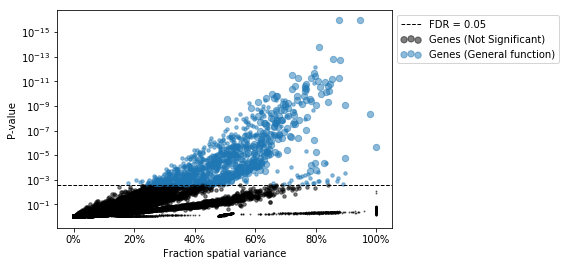

In [24]:
SpatialDE.plot.FSV_sig(results)

In [25]:
results.query('qval < 0.05').l.value_counts()

126.128432    366
65.188408     301
244.036967    154
33.692075     147
17.413462      32
472.169837     10
Name: l, dtype: int64

In [26]:
results.query('qval < 0.05 & l > 100').sort_values('FSV', ascending=False).head(15)[['g', 'l', 'qval', 'FSV']]

,g,l,qval,FSV
20259,ENSDARG00000070352_hoxc12a,472.169837,1.218306e-06,0.980114
17280,ENSDARG00000004712_tbr1b,126.128432,3.335185e-07,0.897112
20161,ENSDARG00000095715_BX465834.1,244.036967,4.331286e-02,0.889115
18017,ENSDARG00000036832_cyt1l,126.128432,7.281206e-10,0.855317
19951,ENSDARG00000070546_msgn1,244.036967,1.058936e-08,0.853156
19440,ENSDARG00000007099_cx43.4,244.036967,4.734528e-08,0.842311
19334,ENSDARG00000094041_krt17,126.128432,2.509206e-08,0.841733
17648,ENSDARG00000019365_zgc:110712,126.128432,1.990785e-07,0.840508
19982,ENSDARG00000074772_ccl44,244.036967,3.427289e-02,0.836121
19679,ENSDARG00000037840_ENSDARG00000037840,244.036967,1.679850e-08,0.831907


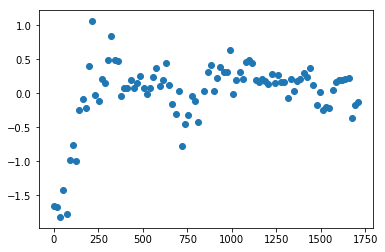

In [27]:
plt.scatter(sample_info.x, res['ENSDARG00000036832_cyt1l']);

In [28]:
results.head().T

,0,1,2,3,4
FSV,0.149886,2.05533e-09,2.05533e-09,2.05533e-09,0.775817
M,4,4,4,4,4
g,ENSDARG00000000001_slc35a5,ENSDARG00000000069_dap,ENSDARG00000000086_itsn1,ENSDARG00000000103_myh10,ENSDARG00000000151_thraa
l,9,9,9,9,9
max_delta,5.65573,4.85165e+08,4.85165e+08,4.85165e+08,0.288147
max_ll,12.6879,-30.3899,-69.0624,-26.9309,-6.26816
max_mu_hat,0.000174834,2.02781e-12,-2.05102e-12,-2.59315e-13,-3.83475e-05
max_s2_t_hat,0.00673753,2.28819e-10,5.16507e-10,2.12748e-10,0.0524371
model,SE,SE,SE,SE,SE
n,95,95,95,95,95


In [29]:
total_var = (1 + results.max_delta) * results.max_s2_t_hat

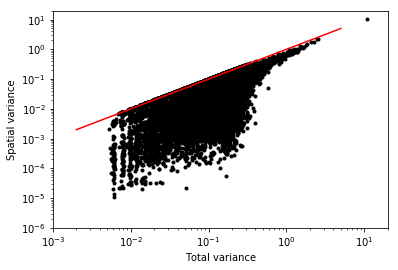

In [30]:
plt.scatter(total_var, results.max_s2_t_hat, marker='.', c='k')
plt.loglog()
plt.xlim(1e-3, 2e1)
plt.ylim(1e-6, 2e1);
plt.plot([2e-3, 5e0], [2e-3, 5e0], c='r');
plt.xlabel('Total variance')
plt.ylabel('Spatial variance');

In [31]:
results['total_var'] = total_var

In [32]:
results.sort_values('total_var', ascending=False).head()

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval,total_var
20259,0.980114,4,ENSDARG00000070352_hoxc12a,472.169837,0.009566,-44.335273,1.554134,10.622827,SE,95,0.000119,0.236804,0.000738,106.886053,-78.605278,34.270005,4.797187e-09,1.218306e-06,10.724446
19951,0.853156,4,ENSDARG00000070546_msgn1,244.036967,0.119441,-89.381996,0.608609,2.296660,SE,95,0.001794,0.106805,0.000832,196.979500,-136.473248,47.091252,6.775691e-12,1.058936e-08,2.570976
19679,0.831907,4,ENSDARG00000037840_ENSDARG00000037840,244.036967,0.140217,-93.423331,-0.447397,2.155112,SE,95,0.002479,0.121778,0.000813,205.062169,-139.329994,45.906664,1.240230e-11,1.679850e-08,2.457294
19853,0.728639,4,ENSDARG00000057911_ACTC1,244.036967,0.258440,-110.751398,-0.467278,1.776294,SE,95,0.004725,0.129135,0.000686,239.718303,-146.327073,35.575675,2.453320e-09,7.120586e-07,2.235360
19636,0.795316,4,ENSDARG00000032242_tnnt2c,244.036967,0.178595,-94.090384,-0.512511,1.756339,SE,95,0.002673,0.101143,0.000763,206.396275,-139.784499,45.694115,1.382372e-11,1.755353e-08,2.070012


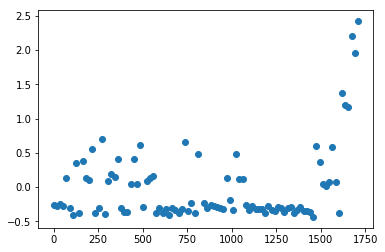

In [33]:
figsize(6, 4)
plt.scatter(sample_info.x, res['ENSDARG00000070352_hoxc12a']);

In [40]:
sig_res = results.query('qval < 0.05').copy()

In [41]:
sig_res.l.value_counts()

126.128432    366
65.188408     301
244.036967    154
33.692075     147
17.413462      32
472.169837     10
Name: l, dtype: int64

In [42]:
pattern_results, patterns = SpatialDE.spatial_patterns(X, res, sig_res, 10, 150, verbosity=1)

iter 0, ELBO: -6.81e+10
iter 1, ELBO: -3.34e+10, delta_ELBO: 3.47e+10
iter 2, ELBO: -3.34e+10, delta_ELBO: 1.22e+04
iter 3, ELBO: -3.34e+10, delta_ELBO: 8.83e+03
iter 4, ELBO: -3.34e+10, delta_ELBO: 1.57e+03
iter 5, ELBO: -3.34e+10, delta_ELBO: 6.03e+02
iter 6, ELBO: -3.34e+10, delta_ELBO: 1.84e+02
iter 7, ELBO: -3.34e+10, delta_ELBO: 8.54e+01
iter 8, ELBO: -3.34e+10, delta_ELBO: 1.22e+02
iter 9, ELBO: -3.34e+10, delta_ELBO: 1.59e+02
iter 10, ELBO: -3.34e+10, delta_ELBO: 6.98e+01
iter 11, ELBO: -3.34e+10, delta_ELBO: 1.45e+01
iter 12, ELBO: -3.34e+10, delta_ELBO: 3.68e+00
iter 13, ELBO: -3.34e+10, delta_ELBO: 8.78e-01
iter 14, ELBO: -3.34e+10, delta_ELBO: 1.43e+00
iter 15, ELBO: -3.34e+10, delta_ELBO: 9.44e-01
iter 16, ELBO: -3.34e+10, delta_ELBO: 7.94e-01
iter 17, ELBO: -3.34e+10, delta_ELBO: 1.52e+00
iter 18, ELBO: -3.34e+10, delta_ELBO: 1.81e+00
iter 19, ELBO: -3.34e+10, delta_ELBO: 1.72e+00
iter 20, ELBO: -3.34e+10, delta_ELBO: 1.53e+00
iter 21, ELBO: -3.34e+10, delta_ELBO: 1.36e+0

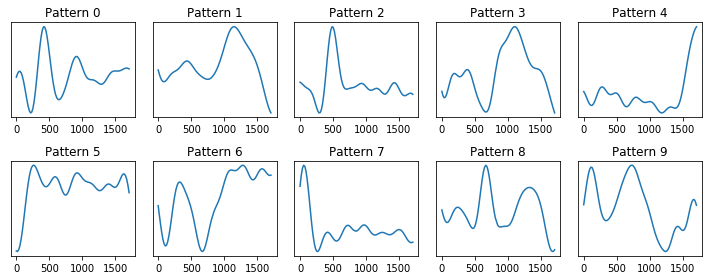

In [44]:
figsize(10, 4)
for p in patterns.columns:
    C = patterns[p]
    plt.subplot(2, 5, p + 1)
    
    plt.plot(sample_info.x, C)
    plt.yticks([])
    plt.title(f'Pattern {p}')
    
plt.tight_layout()

In [45]:
pattern_results.pattern.value_counts()

3    185
1    135
9    121
8    109
7     98
2     94
4     91
5     81
6     67
0     29
Name: pattern, dtype: int64

In [46]:
comb_results = sig_res.join(pattern_results.set_index('g'), on='g')

In [47]:
comb_results.query('pattern == 0').sort_values('pval').head(15)

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,...,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval,total_var,membership,pattern
16637,0.704093,4,ENSDARG00000077121_cyp26b1,65.188408,0.385759,-81.700722,-0.034786,0.494206,SE,95,...,0.042931,0.000705,181.616951,-111.093054,29.392332,5.911107e-08,0.000009,0.684850,0.999999,0
18244,0.700630,4,ENSDARG00000044098_egr2a,126.128432,0.357475,-60.559674,-0.012502,0.402892,SE,95,...,0.064570,0.000682,139.334855,-89.127449,28.567775,9.047545e-08,0.000013,0.546916,0.999344,0
15102,0.526268,4,ENSDARG00000023031_hoxa2b,65.188408,0.826259,-69.626080,-0.000957,0.208593,SE,95,...,0.037549,0.000670,157.467668,-92.278801,22.652721,1.940852e-06,0.000163,0.380945,0.999947,0
14099,0.664786,4,ENSDARG00000086393_dbx1a,33.692075,0.485034,-92.479162,-0.008599,0.421386,SE,95,...,0.029051,0.000685,203.173831,-113.207555,20.728393,5.292539e-06,0.000376,0.625772,0.999923,0
15027,0.506975,4,ENSDARG00000020219_dld,65.188408,0.892629,-39.482385,0.020865,0.103866,SE,95,...,0.037674,0.000687,97.180277,-59.462025,19.979641,7.827112e-06,0.000519,0.196579,0.967334,0
18201,0.514015,4,ENSDARG00000042826_egr2b,126.128432,0.790994,-102.069871,-0.018363,0.481099,SE,95,...,0.076419,0.000676,222.355250,-121.896532,19.826661,8.479171e-06,0.000545,0.861646,0.969026,0
15555,0.529013,4,ENSDARG00000039243_zgc:152791,65.188408,0.817207,5.546068,-0.006262,0.043245,SE,95,...,0.035169,0.000742,7.123372,-14.268429,19.814497,8.533302e-06,0.000545,0.078586,0.903800,0
13300,0.592982,4,ENSDARG00000055589_s100t,33.692075,0.660243,-27.802694,-0.006519,0.087766,SE,95,...,0.024921,0.000748,73.820896,-44.756389,16.953695,3.830271e-05,0.001853,0.145712,0.973866,0
12642,0.610757,4,ENSDARG00000020103_ENSDARG00000020103,33.692075,0.613033,-38.371963,0.002622,0.115326,SE,95,...,0.042153,0.000675,94.959433,-53.929831,15.557868,8.001795e-05,0.003352,0.186025,0.660914,0
14955,0.438060,4,ENSDARG00000018397_hpca,65.188408,1.177458,-90.230799,0.010007,0.240446,SE,95,...,0.041856,0.000710,198.677106,-105.740322,15.509523,8.209065e-05,0.003418,0.523561,1.000000,0


In [770]:
def nice_x_axis(n=7):
    locs = np.linspace(0, 1800, n)
    labs = locs.copy().astype(int).astype(str)
    labs[0] = '0\n(Head)'
    labs[-1] = '1800\n(Tail)'
    plt.xticks(locs, labs)
    plt.xlim(-100, 1850)
    plt.xlabel('Position (µm)');

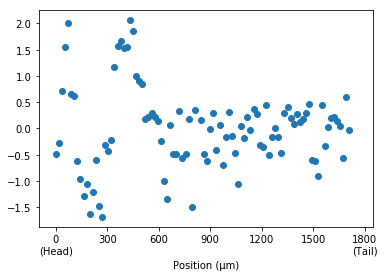

In [97]:
figsize(6, 4)
g = 'ENSDARG00000077121_cyp26b1'
plt.scatter(sample_info.x, res[g]);
nice_x_axis()

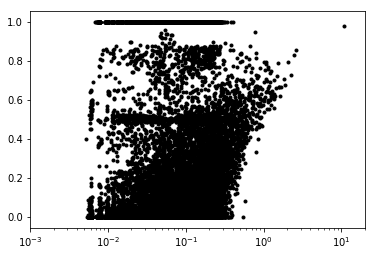

In [102]:
plt.scatter(results.total_var, results.FSV, marker='.', c='k')
plt.xscale('log')
plt.xlim(1e-3, 2e1);

In [119]:
results.query('total_var > 1e-1 & FSV < 0.1').sample()

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval,total_var
16266,0.018978,4,ENSDARG00000063021_rpain,65.188408,47.448912,-67.820149,0.000745,0.005044,SE,95,0.044915,97.659304,0.002066,153.855806,-67.866237,0.046087,0.830017,0.958943,0.244377


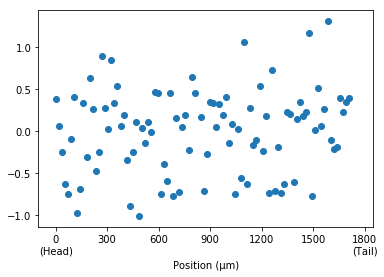

In [120]:
figsize(6, 4)
g = 'ENSDARG00000063021_rpain'
plt.scatter(sample_info.x, res[g]);
nice_x_axis()

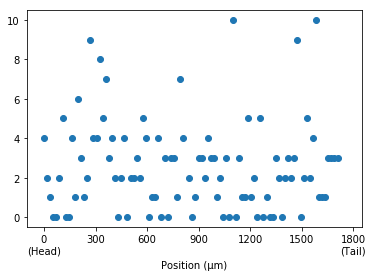

In [121]:
plt.scatter(sample_info.x, counts[g]);
nice_x_axis()

In [123]:
gene_info = pd.DataFrame({'mean_counts': counts.mean()})

In [293]:
results = results.join(gene_info, on='g')

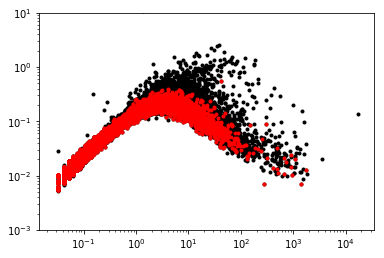

In [298]:
plt.scatter(results.mean_counts, results.total_var, marker='.', c='k')
tmp = results.query('FSV < 0.05')
plt.scatter(tmp.mean_counts, tmp.total_var, marker='.', c='r')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3, 1e1);

In [309]:
results.query('mean_counts > 1e2 & FSV < 0.05').sort_values('total_var', ascending=True).head()

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval,total_var,mean_counts
10296,2.055329e-09,4,ERCC-00096_ERCC-00096,9.000000,4.851652e+08,100.458355,1.320887e-13,1.455932e-11,SE,95,0.483538,8.287880e+16,0.000674,-182.701202,100.455704,0.002650,0.958943,0.958943,0.007064,275.494737
20199,3.591918e-02,4,ENSDARG00000021864_rplp1,472.169837,1.265443e+01,101.815270,-4.162727e-03,5.221713e-04,SE,95,0.007431,4.830680e+00,0.000813,-185.415032,100.953345,0.861925,0.353200,0.958943,0.007130,1406.294737
2854,2.055329e-09,4,ENSDARG00000036629_rps14,9.000000,4.851652e+08,83.493712,-9.562809e-13,2.080892e-11,SE,95,0.657002,1.126106e+17,0.000653,-148.771916,83.491061,0.002650,0.958943,0.958943,0.010096,959.926316
14775,2.810682e-02,4,ENSDARG00000013012_ENSDARG00000013012,65.188408,3.173923e+01,81.534963,-2.557574e-05,3.220606e-04,SE,95,0.024243,2.494009e+01,0.001466,-144.854419,81.433382,0.101581,0.749940,0.958943,0.010544,656.515789
10266,2.055329e-09,4,ERCC-00002_ERCC-00002,9.000000,4.851652e+08,78.302741,-1.528203e-13,2.321191e-11,SE,95,0.358753,6.149054e+16,0.000853,-138.389974,78.300090,0.002650,0.958943,0.958943,0.011262,524.084211


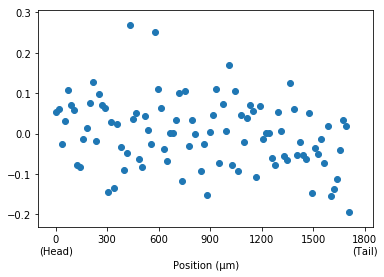

In [321]:
figsize(6, 4)
g = 'ENSDARG00000021864_rplp1'
plt.scatter(sample_info.x, res[g]);
nice_x_axis()

(1, 10000.0)

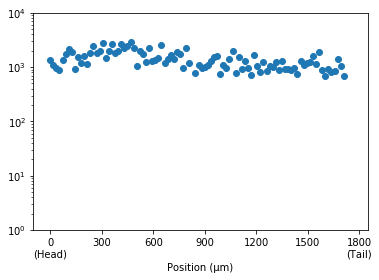

In [322]:
plt.scatter(sample_info.x, counts[g]);
nice_x_axis()
plt.yscale('log')
plt.ylim(1 , 1e4)

In [323]:
results.sort_values('mean_counts', ascending=False).head()

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval,total_var,mean_counts
16784,0.479223,4,ENSDARG00000080337_AC024175.4,65.188408,0.997478,-23.911427,0.010474,0.068291,SE,95,0.002952,0.055449,0.000582,66.038362,-40.642513,16.731086,0.000043,0.002017,0.136410,17614.505263
17688,0.292669,4,ENSDARG00000020850_eef1a1l2,126.128432,2.021958,60.082340,0.007496,0.006829,SE,95,0.006124,0.155226,0.000663,-101.949173,53.319302,6.763038,0.009307,0.136619,0.020637,3620.568421
17078,0.231025,4,ENSDARG00000092807_RPL41,65.188408,3.055224,85.161883,-0.001778,0.002649,SE,95,0.003730,0.121781,0.000749,-152.108258,80.067981,5.093902,0.024010,0.270857,0.010742,1873.526316
15505,0.498835,4,ENSDARG00000037870_actb2,65.188408,0.922176,37.053806,-0.002412,0.020180,SE,95,0.003407,0.063808,0.000673,-55.892104,24.274019,12.779787,0.000350,0.011066,0.038790,1796.726316
20292,0.038566,4,ENSDARG00000088030_rpl35a,472.169837,11.753626,75.350598,-0.008926,0.000981,SE,95,0.006216,3.542648,0.000679,-132.485688,74.470887,0.879711,0.348281,0.958943,0.012505,1755.305263


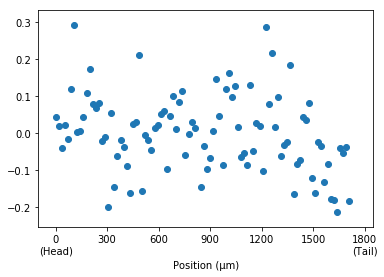

In [330]:
figsize(6, 4)
g = 'ENSDARG00000092807_RPL41'
plt.scatter(sample_info.x, res[g]);
nice_x_axis()

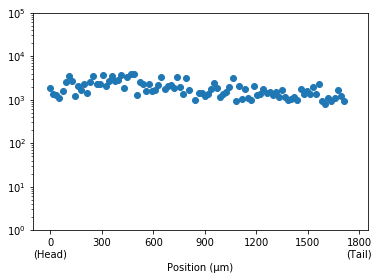

In [331]:
plt.scatter(sample_info.x, counts[g]);
nice_x_axis()
plt.yscale('log')
plt.ylim(1 , 1e5);

In [332]:
results.query('mean_counts > 100').sort_values('pval').head(10)

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval,total_var,mean_counts
18017,0.855317,4,ENSDARG00000036832_cyt1l,126.128432,0.141520,-16.064137,-0.142235,0.351501,SE,95,0.000818,0.049767,0.000857,50.343781,-70.412792,54.348655,1.678657e-13,7.281206e-10,0.401246,436.063158
14933,0.795069,4,ENSDARG00000017624_krt4,65.188408,0.236588,-10.295000,-0.036410,0.160432,SE,95,0.000582,0.021983,0.000960,38.805507,-59.648227,49.353227,2.137845e-12,6.204944e-09,0.198388,979.189474
19334,0.841733,4,ENSDARG00000094041_krt17,126.128432,0.157305,-30.758271,-0.199017,0.438606,SE,95,0.001114,0.059573,0.000906,79.732049,-75.220388,44.462117,2.593270e-11,2.509206e-08,0.507601,216.978947
15463,0.768185,4,ENSDARG00000036834_krt92,65.188408,0.276991,-23.911880,-0.041632,0.189411,SE,95,0.000715,0.023242,0.000737,66.039267,-67.304068,43.392188,4.479728e-11,3.640585e-08,0.241876,303.189474
19440,0.842311,4,ENSDARG00000007099_cx43.4,244.036967,0.129914,23.097924,0.223463,0.199959,SE,95,0.001642,0.088258,0.001445,-27.980341,-19.703484,42.801408,6.058853e-11,4.734528e-08,0.225936,198.452632
17448,0.818406,4,ENSDARG00000011168_ENSDARG00000011168,126.128432,0.185635,-44.197398,-0.152408,0.503785,SE,95,0.001099,0.048610,0.001211,106.610303,-85.747125,41.549727,1.149105e-10,7.782124e-08,0.597305,212.852632
18175,0.662926,4,ENSDARG00000042245_myl13,126.128432,0.425390,-111.447211,-0.181490,1.012938,SE,95,0.002467,0.055237,0.000683,241.109930,-151.532459,40.085247,2.431181e-10,1.400625e-07,1.443831,118.010526
16690,0.739336,4,ENSDARG00000078234_si:dkey-253d23.12,65.188408,0.323614,19.951841,-0.019858,0.066689,SE,95,0.000693,0.019757,0.000752,-21.688174,-19.619232,39.571073,3.163344e-10,1.591382e-07,0.088270,413.031579
18524,0.783836,4,ENSDARG00000058371_krt5,126.128432,0.230720,-19.104014,-0.125405,0.246766,SE,95,0.001766,0.062443,0.000744,56.423536,-58.324458,39.220444,3.785555e-10,1.747980e-07,0.303700,381.263158
17648,0.840508,4,ENSDARG00000019365_zgc:110712,126.128432,0.158754,-52.043942,-0.279440,0.682305,SE,95,0.001833,0.096924,0.001103,122.303392,-90.966579,38.922636,4.409378e-10,1.990785e-07,0.790623,112.589474


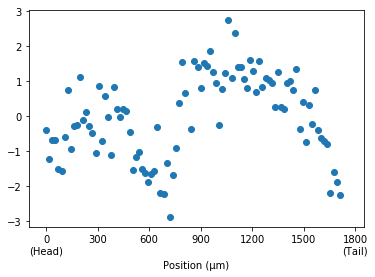

In [257]:
figsize(6, 4)
g = 'ENSDARG00000042245_myl13'
plt.scatter(sample_info.x, res[g]);
nice_x_axis()

(1, 10000.0)

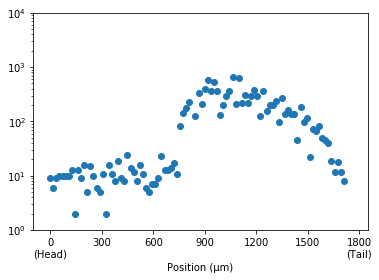

In [258]:
plt.scatter(sample_info.x, counts[g] + 1);
nice_x_axis()
plt.yscale('log')
plt.ylim(1 , 1e4)

In [333]:
results.query('1.1 < total_var').sort_values('pval', ascending=False).head(10)

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval,total_var,mean_counts
20227,0.572236,4,ENSDARG00000039701_emx2,472.169837,0.352440,-88.827840,0.138372,0.908495,SE,95,0.015420,0.298592,0.000822,195.871188,-103.369463,14.541622,0.000137,0.005086,1.228684,6.210526
14221,0.597139,4,ENSDARG00000089806_si:dkey-239j18.3,33.692075,0.648950,-128.487072,-0.006220,0.739582,SE,95,0.001331,0.026497,0.000682,275.189652,-144.239103,15.752031,0.000072,0.003082,1.219534,25.736842
12990,0.619656,4,ENSDARG00000039173_ctslb,33.692075,0.590416,-134.187502,0.004063,0.889275,SE,95,0.001366,0.028082,0.000656,286.590512,-150.928889,16.741387,0.000043,0.002015,1.414317,65.073684
12696,0.604168,4,ENSDARG00000023656_he1a,33.692075,0.630210,-133.226527,-0.002913,0.833706,SE,95,0.001183,0.023761,0.000654,284.668562,-150.295156,17.068628,0.000036,0.001774,1.359116,40.168421
14269,0.612878,4,ENSDARG00000090918_ENSDARG00000090918,33.692075,0.607583,-133.419423,0.009180,0.858199,SE,95,0.001236,0.025147,0.000661,285.054354,-150.993325,17.573902,0.000028,0.001432,1.379627,47.473684
14031,0.628752,4,ENSDARG00000079376_zgc:174153,33.692075,0.567959,-129.687176,0.007225,0.830327,SE,95,0.001085,0.022666,0.000930,277.589860,-148.860374,19.173198,0.000012,0.000709,1.301920,83.926316
13796,0.643604,4,ENSDARG00000074306_ctslb,33.692075,0.532654,-120.869845,0.002696,0.719934,SE,95,0.001133,0.024335,0.000744,259.955198,-140.353379,19.483533,0.000010,0.000614,1.103410,21.673684
14398,0.647294,4,ENSDARG00000095254_si:dkey-239j18.2,33.692075,0.524134,-127.119719,0.014531,0.830082,SE,95,0.001101,0.023826,0.000795,272.454946,-146.884834,19.765115,0.000009,0.000553,1.265156,58.578947
20210,0.674268,4,ENSDARG00000031483_col9a1b,472.169837,0.227763,-92.870375,-0.845062,1.513510,SE,95,0.018058,0.415812,0.000656,203.956258,-112.670310,19.799935,0.000009,0.000545,1.858232,47.200000
19462,0.639769,4,ENSDARG00000009461_ENSDARG00000009461,244.036967,0.390736,-93.575967,0.128039,0.842681,SE,95,0.006295,0.134161,0.000671,205.367441,-114.084327,20.508360,0.000006,0.000416,1.171946,8.600000


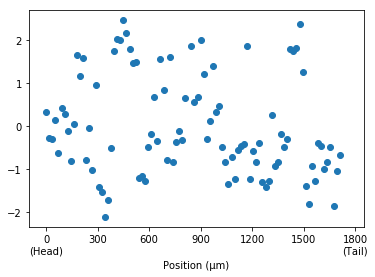

In [286]:
figsize(6, 4)
g = 'ENSDARG00000079376_zgc:174153'
plt.scatter(sample_info.x, res[g]);
nice_x_axis()

(1, 10000.0)

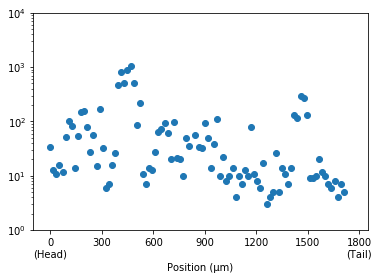

In [287]:
plt.scatter(sample_info.x, counts[g] + 1);
nice_x_axis()
plt.yscale('log')
plt.ylim(1 , 1e4)

In [338]:
results.sort_values('total_var', ascending=False).query('qval > 0.05').head(20)

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval,total_var,mean_counts
17115,8.033182e-02,4,ENSDARG00000093831_znf1121,65.188408,1.050832e+01,-108.336627,1.341855e-03,5.055415e-02,SE,95,0.007927,1.227055e+00,0.002178,234.888761,-109.098839,0.762212,0.382637,0.958943,0.581793,5.168421
16930,3.226590e-01,4,ENSDARG00000088967_wnk4b,65.188408,1.926873e+00,-97.900499,-2.329415e-02,1.864995e-01,SE,95,0.003182,7.384806e-02,0.000676,214.016505,-106.544060,8.643561,0.003282,0.061574,0.545860,6.568421
9160,2.055329e-09,4,ENSDARG00000091334_ENSDARG00000091334,9.000000,4.851652e+08,-105.468715,-3.566685e-12,1.111580e-09,SE,95,0.185267,3.175497e+16,0.000856,229.152937,-105.471365,0.002650,0.958943,0.958943,0.539300,41.905263
17823,3.528868e-01,4,ENSDARG00000029179_foxd1,126.128432,1.534163e+00,-90.390587,7.296788e-02,2.084791e-01,SE,95,0.013578,2.936426e-01,0.000701,198.996682,-98.467489,8.076902,0.004483,0.077986,0.528320,5.284211
19944,3.861092e-01,4,ENSDARG00000070339_hoxc3a,244.036967,1.103333e+00,-81.162510,1.039455e-02,2.475075e-01,SE,95,0.015143,3.085721e-01,0.000581,180.540527,-89.797261,8.634751,0.003298,0.061758,0.520591,16.210526
17563,2.450090e-01,4,ENSDARG00000015775_ENSDARG00000015775,126.128432,2.578022e+00,-95.245210,-4.000416e-02,1.440185e-01,SE,95,0.007224,2.204473e-01,0.000652,208.705927,-100.729566,5.484356,0.019187,0.231904,0.515301,5.578947
11717,3.728283e-01,4,ENSDARG00000076434_ARHGAP22 (1 of many),17.413462,1.657287e+00,-100.763434,6.169905e-03,1.930320e-01,SE,95,0.010739,2.236363e-01,0.000682,219.742376,-103.295423,2.531988,0.111560,0.729438,0.512941,9.978947
16363,3.106932e-01,4,ENSDARG00000069503_cldnh,65.188408,2.036434e+00,-93.482896,-1.756111e-02,1.620474e-01,SE,95,0.004317,1.035393e-01,0.000656,205.181299,-100.594906,7.112010,0.007657,0.118521,0.492046,4.126316
12742,2.913011e-01,4,ENSDARG00000027279_numb,33.692075,2.340191e+00,-96.868979,-2.334198e-02,1.461008e-01,SE,95,0.008178,2.082265e-01,0.000647,211.953465,-99.549476,2.680497,0.101584,0.693714,0.488005,25.263158
17365,4.012571e-01,4,ENSDARG00000007641_msx1a,126.128432,1.248373e+00,-83.225616,-2.415600e-02,2.154986e-01,SE,95,0.010967,2.187335e-01,0.000679,184.666741,-91.620386,8.394769,0.003763,0.067898,0.484521,11.526316


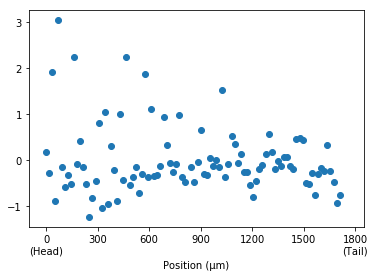

In [343]:
figsize(6, 4)
g = 'ENSDARG00000091334_ENSDARG00000091334'
plt.scatter(sample_info.x, res[g]);
nice_x_axis()

(1, 10000.0)

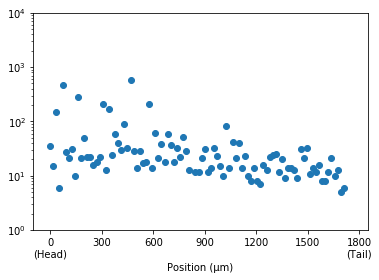

In [344]:
plt.scatter(sample_info.x, counts[g] + 1);
nice_x_axis()
plt.yscale('log')
plt.ylim(1 , 1e4)

In [521]:
comb_results.l.value_counts()

126.128432    366
65.188408     301
244.036967    154
33.692075     147
17.413462      32
472.169837     10
Name: l, dtype: int64

In [526]:
Sigma = SpatialDE.base.SE_kernel(X, 126)

In [527]:
from scipy import stats

In [558]:

def se_kernel_pred(X1, X2, l):
    X1sq = np.sum(np.square(X1), 1)
    X2sq = np.sum(np.square(X2), 1)
    R2 = -2. * np.dot(X1, X2.T) + (X1sq[:, None] + X2sq[None, :])
    R2 = np.clip(R2, 1e-12, np.inf)
    
    return np.exp(-R2 / (2 * l ** 2))

xx = np.linspace(0, 1800, 512)[:, None]
K_s = se_kernel_pred(xx, X, 126)


def predict_gp(X_new, Y, K, K_s, s2, delta, mu):
    Y_new = mu + s2 * K_s.dot(np.linalg.solve(s2 * K + s2 * delta * np.eye(K.shape[0]), Y - mu))
    return Y_new

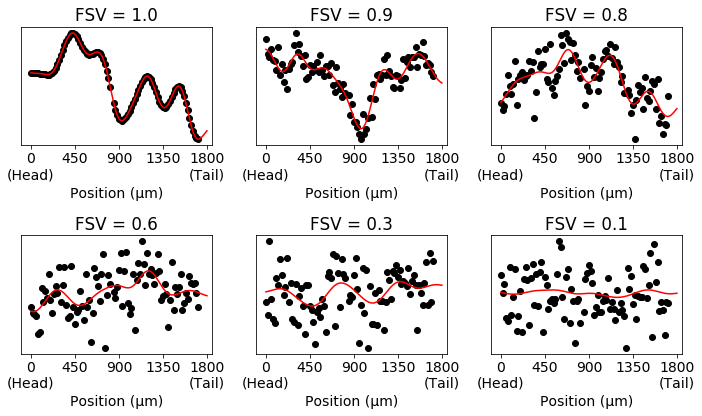

In [796]:
figsize(10, 6)

with plt.rc_context(rc={'font.size': 14}):
    i = 0
    for fsv in [1., 0.9, 0.8, 0.6, 0.3, 0.1]:
        delta = 1 / fsv - 1

        i += 1
        plt.subplot(2, 3, i)

        K = Sigma + np.eye(95) * (delta + 1e-8)
        yy = stats.multivariate_normal(np.zeros((95,)), K).rvs()
        plt.scatter(X, yy, c='k')

        yyf = predict_gp(xx, yy, K, K_s, 1, delta, 0)
        plt.plot(xx, yyf, c='r')

        nice_x_axis(5)
        plt.yticks([])
        plt.title(f'FSV = {fsv:0.2}')

    plt.tight_layout()
    plt.savefig('3.png', dpi=200)

In [578]:
results.query('FSV > 0.8 & l > 120').sort_values('mean_counts', ascending=False).head()

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval,total_var,mean_counts
18017,0.855317,4,ENSDARG00000036832_cyt1l,126.128432,0.141520,-16.064137,-0.142235,0.351501,SE,95,0.000818,0.049767,0.000857,50.343781,-70.412792,54.348655,1.678657e-13,7.281206e-10,0.401246,436.063158
19334,0.841733,4,ENSDARG00000094041_krt17,126.128432,0.157305,-30.758271,-0.199017,0.438606,SE,95,0.001114,0.059573,0.000906,79.732049,-75.220388,44.462117,2.593270e-11,2.509206e-08,0.507601,216.978947
17448,0.818406,4,ENSDARG00000011168_ENSDARG00000011168,126.128432,0.185635,-44.197398,-0.152408,0.503785,SE,95,0.001099,0.048610,0.001211,106.610303,-85.747125,41.549727,1.149105e-10,7.782124e-08,0.597305,212.852632
19440,0.842311,4,ENSDARG00000007099_cx43.4,244.036967,0.129914,23.097924,0.223463,0.199959,SE,95,0.001642,0.088258,0.001445,-27.980341,-19.703484,42.801408,6.058853e-11,4.734528e-08,0.225936,198.452632
17648,0.840508,4,ENSDARG00000019365_zgc:110712,126.128432,0.158754,-52.043942,-0.279440,0.682305,SE,95,0.001833,0.096924,0.001103,122.303392,-90.966579,38.922636,4.409378e-10,1.990785e-07,0.790623,112.589474


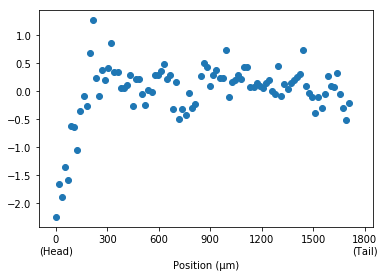

In [595]:
figsize(6, 4)
g = 'ENSDARG00000094041_krt17'
plt.scatter(sample_info.x, res[g]);
nice_x_axis()

In [580]:
results.query('0.6 < FSV < 0.8 & l > 120').sort_values('mean_counts', ascending=False).head()

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval,total_var,mean_counts
20046,0.648662,4,ENSDARG00000079193_ENSDARG00000079193,244.036967,0.375866,3.653397,0.117062,0.113205,SE,95,0.005798,0.125788,0.000785,10.908714,-30.545499,34.198896,4.975717e-09,1.248045e-06,0.155755,1443.947368
19613,0.669583,4,ENSDARG00000029150_hsp90ab1,244.036967,0.342439,56.624647,0.073013,0.040456,SE,95,0.007482,0.170260,0.000678,-95.033786,20.776528,35.848118,2.133139e-09,6.496761e-07,0.054310,1102.505263
18524,0.783836,4,ENSDARG00000058371_krt5,126.128432,0.230720,-19.104014,-0.125405,0.246766,SE,95,0.001766,0.062443,0.000744,56.423536,-58.324458,39.220444,3.785555e-10,1.747980e-07,0.303700,381.263158
18957,0.614813,4,ENSDARG00000076532_si:ch211-222l21.1,126.128432,0.524151,28.087970,0.019003,0.044654,SE,95,0.002885,0.058872,0.000677,-37.960432,-7.563954,35.651924,2.359148e-09,6.946493e-07,0.068059,352.631579
19376,0.661007,4,ENSDARG00000095863_afp4,126.128432,0.429054,-100.215447,-0.120663,0.792962,SE,95,0.002398,0.053465,0.000684,218.646401,-130.029890,29.814444,4.754367e-08,7.437557e-06,1.133187,181.705263


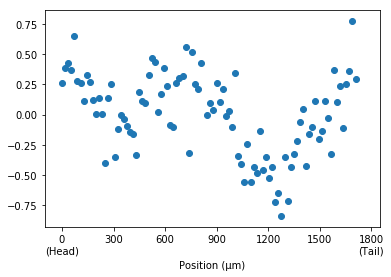

In [583]:
figsize(6, 4)
g = 'ENSDARG00000079193_ENSDARG00000079193'
plt.scatter(sample_info.x, res[g]);
nice_x_axis()

In [584]:
results.query('0.3 < FSV < 0.6 & l > 120').sort_values('mean_counts', ascending=False).head()

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval,total_var,mean_counts
19016,0.463928,4,ENSDARG00000077777_tmsb4x,126.128432,0.966715,-1.588167,-0.034152,0.048616,SE,95,0.005931,0.112014,0.000759,21.391841,-18.580126,16.991959,0.000038,0.001820,0.095613,1599.642105
19580,0.332612,4,ENSDARG00000021838_rps23,244.036967,1.392405,56.582536,-0.009194,0.010959,SE,95,0.017354,0.392795,0.000674,-94.949564,48.848797,7.733739,0.005420,0.090110,0.026218,1123.105263
17806,0.366173,4,ENSDARG00000028335_hmga1a,126.128432,1.448141,67.032389,0.016347,0.007989,SE,95,0.004936,0.104013,0.000647,-115.849270,55.014923,12.017466,0.000527,0.015039,0.019559,785.726316
19947,0.340518,4,ENSDARG00000070437_rpl22,244.036967,1.343968,64.862549,-0.014978,0.009521,SE,95,0.007965,0.176962,0.000686,-111.509591,52.950442,11.912108,0.000558,0.015781,0.022318,630.505263
17662,0.301907,4,ENSDARG00000019778_rps6,126.128432,1.934492,59.770379,-0.001750,0.007152,SE,95,0.005512,0.135694,0.000785,-101.325251,49.670373,10.100007,0.001483,0.033620,0.020989,622.768421


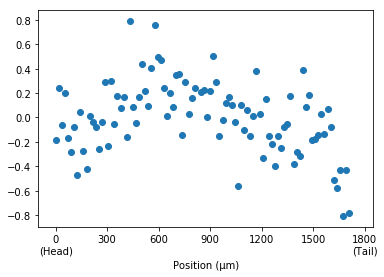

In [585]:
figsize(6, 4)
g = 'ENSDARG00000077777_tmsb4x'
plt.scatter(sample_info.x, res[g]);
nice_x_axis()

In [586]:
results.query('FSV < 0.3 & l > 120').sort_values('mean_counts', ascending=False).head()

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval,total_var,mean_counts
17688,0.292669,4,ENSDARG00000020850_eef1a1l2,126.128432,2.021958,60.082340,0.007496,0.006829,SE,95,0.006124,0.155226,0.000663,-101.949173,53.319302,6.763038,0.009307,0.136619,0.020637,3620.568421
20292,0.038566,4,ENSDARG00000088030_rpl35a,472.169837,11.753626,75.350598,-0.008926,0.000981,SE,95,0.006216,3.542648,0.000679,-132.485688,74.470887,0.879711,0.348281,0.958943,0.012505,1755.305263
19481,0.140701,4,ENSDARG00000011405_rps9,244.036967,4.238102,76.738287,0.001653,0.002506,SE,95,0.011704,0.741970,0.000679,-135.261066,74.423673,2.314614,0.128163,0.784713,0.013127,1549.115789
20199,0.035919,4,ENSDARG00000021864_rplp1,472.169837,12.654426,101.815270,-0.004163,0.000522,SE,95,0.007431,4.830680,0.000813,-185.415032,100.953345,0.861925,0.353200,0.958943,0.007130,1406.294737
17985,0.235456,4,ENSDARG00000036044_rps20,126.128432,2.716564,45.953971,-0.004389,0.007021,SE,95,0.003966,0.126669,0.000742,-73.692435,37.360426,8.593545,0.003374,0.062693,0.026095,1295.894737


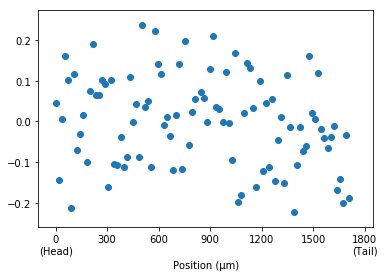

In [590]:
figsize(6, 4)
g = 'ENSDARG00000088030_rpl35a'
plt.scatter(sample_info.x, res[g]);
nice_x_axis()

In [ ]:
matplotlib.rcParams.update()


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.8 to DejaVu Sans ('/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0 to DejaVu Sans ('/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


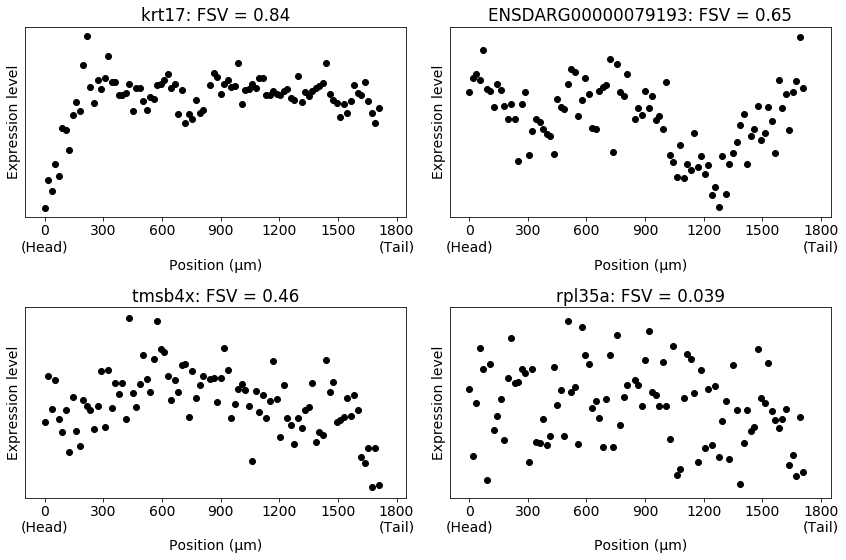

In [767]:
figsize(12, 8)

example_genes = ['ENSDARG00000094041_krt17', 'ENSDARG00000079193_ENSDARG00000079193',
                 'ENSDARG00000077777_tmsb4x', 'ENSDARG00000088030_rpl35a']

with plt.rc_context(rc={'font.size': 14}):
    i = 0
    for g in  example_genes:

        i += 1
        plt.subplot(2, 2, i)
        g_fit = results.set_index('g').loc[g]

        plt.scatter(sample_info.x, res[g], c='k');

        nice_x_axis()
        plt.yticks([])
        plt.ylabel('Expression level');

        g_name = g.split('_')[-1]
        plt.title(f'{g_name}: FSV = {g_fit.FSV:.2}');

    plt.tight_layout()
    plt.savefig('4.png', dpi=200)

In [811]:
junker_genes = ['ENSDARG00000068761_mespab', 'ENSDARG00000017078_mespaa', 'ENSDARG00000042826_egr2b',
                'ENSDARG00000058008_six3a', 'ENSDARG00000036292_cdx4', 'ENSDARG00000015072_dmrt2a',
                'ENSDARG00000070535_ripply2', 'ENSDARG00000054103_ripply1', 'ENSDARG00000006467_pcdh8',
                'ENSDARG00000011785_tbx6', 'ENSDARG00000013477_gata1a', 'ENSDARG00000019920_lft1',
                'ENSDARG00000019096_myl7', 'ENSDARG00000059073_gsc', ]

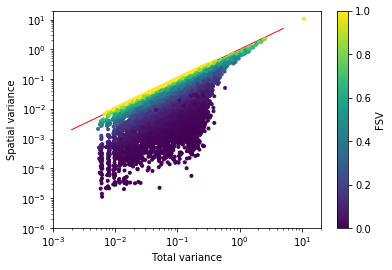

In [760]:
figsize(6, 4)


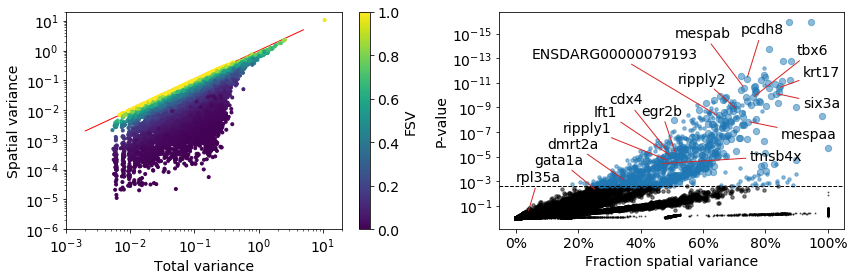

In [932]:
figsize(12, 4)

manual_place = {
    'pcdh8': (0.72, 1e-15),
    'six3a': (0.92, 1e-9),
    'mespab': (0.51, 2e-15),
    'mespaa': (0.85, 3e-7),
    'tbx6': (0.9, 5e-14),
    'cdx4': (0.3, 5e-10),
    'egr2b': (0.4, 4e-9),
    'lft1': (0.25, 5e-9),
    'ripply1': (0.15, 1e-7),
    'dmrt2a': (0.1, 2e-6),
    'gata1a': (0.06, 4e-5),
    'ENSDARG00000079193': (0.05, 1e-13),
    'rpl35a': (0.0, 1e-3),
    'krt17': (0.92, 3e-12),
    'ripply2': (0.52, 1e-11),
    'tmsb4x': (0.75, 2e-5)
}

with plt.rc_context(rc={'font.size': 14}):
    
    plt.subplot(1, 2, 1)
    
    plt.scatter(results.total_var, results.max_s2_t_hat, marker='.', c=results.FSV, vmin=0, vmax=1)
    plt.colorbar(label='FSV')
    plt.loglog()
    plt.xlim(1e-3, 2e1)
    plt.ylim(1e-6, 2e1);
    plt.plot([2e-3, 5e0], [2e-3, 5e0], c='r', lw=1, zorder=0);
    plt.xlabel('Total variance')
    plt.ylabel('Spatial variance');
    
    plt.subplot(1, 2, 2)
    
    SpatialDE.plot.FSV_sig(results)

    tmp = results.query('g in @junker_genes')

    for i, r in tmp.iterrows():
        xy = (r['FSV'], r['pval'])
        xyt = (xy[0] - 0.4, xy[1] * 1e-3)
        gn = r['g'].split('_')[-1]
        plt.annotate(gn, xy, manual_place.get(gn, xyt), arrowprops={'arrowstyle': '-', 'color': 'tab:red'})
        
    tmp = results.query('g in @example_genes')

    for i, r in tmp.iterrows():
        xy = (r['FSV'], r['pval'])
        xyt = (xy[0], xy[1])
        gn = r['g'].split('_')[-1]
        plt.annotate(gn, xy, manual_place.get(gn, xyt), arrowprops={'arrowstyle': '-', 'color': 'tab:red'})
        
    plt.gca().legend_.remove()
        
plt.tight_layout()
plt.savefig('5.png', dpi=200)

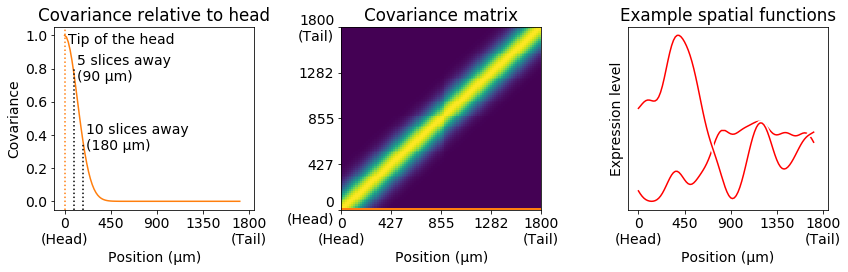

In [793]:
figsize(12, 4)

with plt.rc_context(rc={'font.size': 14}):

    plt.subplot(1, 3, 1)

    i = -1
    plt.plot(X, Sigma[i], c='C1')
    plt.axvline(X[i], ymax=Sigma[i, i], c='C1', ls=':')
    plt.axvline(X[i - 5], ymax=Sigma[i, i - 5], c='k', ls=':')
    plt.annotate('Tip of the head', (X[i] + 30, Sigma[i, i] - 0.05))
    plt.annotate('5 slices away \n(90 µm)', (X[i - 5] + 30, Sigma[i, i - 5] - 0.05))
    plt.annotate('10 slices away \n(180 µm)', (X[i - 10] + 30, Sigma[i, i - 10] - 0.05))
    plt.axvline(X[i - 10], ymax=Sigma[i, i - 10], c='k', ls=':')
    nice_x_axis(5)
    plt.ylabel('Covariance');

    plt.title('Covariance relative to head')

    plt.subplot(1, 3, 2)

    plt.pcolormesh(Sigma)

    locs = np.linspace(0, 95, 5)
    labs = (locs * 18).astype(int).astype(str)
    labs[0] = '0\n(Head)'
    labs[-1] = '1800\n(Tail)'
    plt.xticks(locs, labs)
    plt.xlabel('Position (µm)');
    plt.yticks(locs, labs)
    plt.axhline(X[i], c='C1', lw=4)

    plt.title('Covariance matrix')

    plt.subplot(1, 3, 3)

    for j in range(2):
        K = Sigma + np.eye(95) * 1e-8
        yy = stats.multivariate_normal(np.zeros((95,)), K).rvs()
        plt.plot(X, yy, c='w', lw=5)
        plt.plot(X, yy, c='r')

    nice_x_axis(5)
    plt.yticks([])
    plt.ylabel('Expression level')

    plt.title('Example spatial functions')

    plt.tight_layout()
    plt.savefig('2.png', dpi=200)

In [784]:
Sigma[-1, -11], Sigma[-1, -6]

(0.360447788597821, 0.7748374288832494)

In [649]:
5 * 18, 10 * 18

(90, 180)